In [1]:
### Notebook for Domain Adaptation in QSAR
# Based on data from FLuid Notebook
# Need to find a way to pull the datasets from this and use them here


import torch
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'mps'
# get this to work using mps
print(f"Using {device} device")

Using cpu device


In [2]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

# device = "cpu"

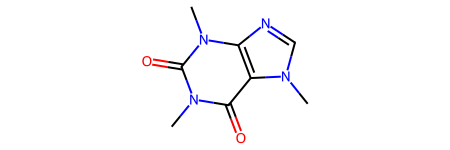

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True 
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")


In [4]:
#Center output
#from IPython.display import display, HTML
CSS = """
.output {
    align-items: center;
}
"""
#HTML('<style>{}</style>'.format(CSS))

# Enables large output display
#from IPython.core.display import display, HTML
#display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from IPython.display import display, HTML

def show(obj):
  display(HTML(obj.to_html(escape=False)))


In [5]:
# First we need to load in the data from the fluid notebook
# TODO setup script to generate and then pull data from fluid notebook
# then load data



In [6]:
from IPython.display import display
import FLuID as fluid
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# import parameters ### TODO actually extract parameters to a separate file

import parameters.base_parameters as parameters

print(parameters.lhasa_params)


k = 8

params = {
    
    # experiment details
    'details' : 3,                  # level of detail of the experiment (low=1,medium=2,high=3,full=4)
    
    # datafiles
'training_data_file' : 'hERG_lhasa_training',
    'test_data_file' : 'hERG_lhasa_test',
'transfer_data_file' : 'FLuID_full',
  'fluid_label_file' : 'FLuID_labels',
    
    # data sampling
   'validation_ratio': 0.2,         # ratio validation/training
     'transfer_size' : 50000 ,      # sample for the transfer data (-1 = all)
         'test_size' : -1,          # sample for the test data (-1 = all)
     'training_size' : -1,          # sample for the training data (-1 = all)

    # number of teacher/clusters (kMean)
                 'k' : k,           # number of clusters (kMean)
     'smooth_factor' : 0.05,        # level of post-clustering mixing to avoid fully biased teachers
    
    # teachers
 'teacher_algorithm' : 'rf',        # algorithm used to build the teacher models
    
    # students
 'federated_student' : 'F' + str(k),
      'student_size' : 10000,                                              # size of the student (number of labelled Cronos data used)
      'student_sizes' : [100,250,500, 1000,2500,5000,10000,25000,50000],   # sizes of the student ti study the impact of the size
 'student_algorithm' : 'rf',                                               # default algorithm used to build the student models
      'student_mode' : 'balanced',                                         # default mode used to select the student data 
    
    # random seed for reproductibility
      'random_state' : 42,

    # t-SNE settings
         'tsne_size' : 500,
   'tsne_iterations' : 1000,
    
    # replication level
    'replicate_count' : 3,
    
    # fonts
       'figure_font' : dict(family="Arial",size=14,color="black"),
 'small_figure_font' : dict(family="Arial",size=10,color="black"),

    # colors
'figure_color_scale' : [(0,"red"),(0.2,"orange"), (0.3,'yellow'),(1,'green')],
        'bar_colors' : px.colors.qualitative.Prism,
         'green_map' : plt.get_cmap('Greens')
}

base_params = params.copy()


base_params["FP_type"] = "ECFP4"
base_params["FP_radius"] = 2
base_params["FP_length"] = 2**11


base_params["regressor_layers"] = [base_params["FP_length"], 
                                   base_params["FP_length"], 
                                   base_params["FP_length"]//2**2, 
                                   base_params["FP_length"]//2**4, 
                                   1] # slightly modified from the paper to use powers of 2 for convenience
base_params["regressor_dropout"] = [0.33] # taken from paper
base_params["max_epochs"] = 100
base_params["batch_size"] = 2**7
base_params["learning_rate"] = 10**-4 ### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 10**-1
base_params["convergence_threshold"] = 0.01

base_params["convergence_criterion"] = ""

base_params["base_checkpoint_dir"] = "model_checkpoints"
base_params["base_results_dir"] = "model_results"
os.makedirs(base_params["base_results_dir"] , exist_ok=True)

base_params["data_dir"] = "data"

for dataset in ["training_data", "test_data", "transfer_data", "validation_data", "label_table", "federated_data"]:
  base_params[dataset] = os.path.join(base_params["data_dir"], dataset + ".pkl")


FT_params = base_params.copy()



{'details': 3, 'training_data_file': 'hERG_lhasa_training', 'test_data_file': 'hERG_lhasa_test', 'transfer_data_file': 'FLuID_full', 'fluid_label_file': 'FLuID_labels', 'validation_ratio': 0.2, 'transfer_size': 50000, 'test_size': -1, 'training_size': -1, 'k': 8, 'smooth_factor': 0.05, 'teacher_algorithm': 'rf', 'federated_student': 'F8', 'student_size': 10000, 'student_sizes': [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000], 'student_algorithm': 'rf', 'student_mode': 'balanced', 'random_state': 42, 'tsne_size': 500, 'tsne_iterations': 1000, 'replicate_count': 3, 'figure_font': {'family': 'Arial', 'size': 14, 'color': 'black'}, 'small_figure_font': {'family': 'Arial', 'size': 10, 'color': 'black'}, 'figure_color_scale': [(0, 'red'), (0.2, 'orange'), (0.3, 'yellow'), (1, 'green')], 'bar_colors': ['rgb(95, 70, 144)', 'rgb(29, 105, 150)', 'rgb(56, 166, 165)', 'rgb(15, 133, 84)', 'rgb(115, 175, 72)', 'rgb(237, 173, 8)', 'rgb(225, 124, 5)', 'rgb(204, 80, 62)', 'rgb(148, 52, 110)', 'r

In [7]:
import importlib
importlib.reload(fluid)
import numpy as np



In [8]:
### Load datasets -- TODO make this a seperate script to pull from fluid notebook

# Federated - load in transfer data
federated_data = pd.read_pickle(base_params["federated_data"])

# Clean - load in training data
clean_data = pd.read_pickle(base_params["training_data"])

# Validation - load in validation data
validation_data = pd.read_pickle(base_params["validation_data"])


# Target - load in test data
target_data = pd.read_pickle(base_params["test_data"])


#pre calculate fingerprints for all molecules

### Currently just computed within the fluid notebook


### split the data into training and validation sets

### Currently just using the split from the fluid notebook

In [9]:
federated_data.CLASS.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
import numpy as np
from torch.nn.modules.module import Module
from torch import nn 
import torch.nn.functional as F

from data_test_utils import MyDataset



In [11]:
# Generate model 

# load Classifier???
from models import Classifier

model = Classifier()

print(model.parameters)

<bound method Module.parameters of Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)>


In [12]:
# from torch.utils.data import Dataset

# class MyDataset(Dataset):
#     def __init__(self, dataframe):
#         self.dataframe = dataframe
#         self.fp = self.dataframe['FP'].to_numpy()
#         self.labels = self.dataframe['CLASS'].to_numpy()

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         x = torch.tensor(self.fp[index], dtype=torch.float32, device=device)
#         y = torch.tensor(self.labels[index], dtype=torch.float32, device=device)
#         return x, y


In [13]:
# broad tuning on federated dataset
FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

from torch.utils.data import DataLoader

# create a dataloader for the federated data

N = 2**10


federated_loader = MyDataset(federated_data)
validation_loader = MyDataset(validation_data)
training_loader = MyDataset(clean_data)
testing_loader = MyDataset(target_data)

N = 25000
federated_loader = DataLoader(federated_loader, batch_size=N, shuffle=True)

N = 128
validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)
training_loader = DataLoader(training_loader, batch_size=N, shuffle=True)
testing_loader = DataLoader(testing_loader, batch_size=N, shuffle=True)

In [14]:
for idx, layer in enumerate(base_params["regressor_layers"]):
    print(idx, layer)

0 2048
1 2048
2 512
3 128
4 1


In [15]:
from models import save_model, load_model

In [16]:
from models import gradual_fine_tuning

In [17]:
import torch
import torch.optim as optim

import numpy as np
from torch.nn.modules.module import Module
from torch import nn 
import torch.nn.functional as F


from models import train_model

In [18]:
from utils import calculate_tanimoto_similarity, calculate_target_similarity, calculate_set_similarity

In [19]:
device = 'cpu'

In [20]:
from data_test_utils import dataset_compiler, plot_losses

In [21]:
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
os.makedirs(base_params["checkpoint_dir"], exist_ok=True)
base_params["experiment_name"] = "broad_lr_1e-4_wd_0.1"
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 10**-0
model = Classifier()
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"],device='cpu')
plot_losses([train_losses, val_losses], title="Losses on federated dataset")
# save_model(model, params=base_params)

cpu
Epoch 1: Train loss = 1.4735, Val loss = 0.6916, Val BAC = 0.5357


KeyboardInterrupt: 

In [ ]:
for data in validation_loader:
    print(data[0].shape)

torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([18, 2048])


In [ ]:
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
os.makedirs(base_params["checkpoint_dir"], exist_ok=True)
base_params["experiment_name"] = "broad_lr_1e-4_wd_0.1"
base_params["learning_rate"] = 10**-4 ### TODO Check this is correct - find this from the paper

model = Classifier()
model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")
# save_model(model, params=base_params)

cpu
Epoch 1: Train loss = 30.1524, Val loss = 0.5482, Val BAC = 0.6846
Epoch 2: Train loss = 24.1880, Val loss = 0.4626, Val BAC = 0.7125
Epoch 3: Train loss = 20.4212, Val loss = 0.4258, Val BAC = 0.8831
Epoch 4: Train loss = 17.5805, Val loss = 0.4042, Val BAC = 0.9000
Epoch 5: Train loss = 15.0336, Val loss = 0.4077, Val BAC = 0.9000
Epoch 6: Train loss = 12.6850, Val loss = 0.4055, Val BAC = 0.9500
Epoch 7: Train loss = 10.9325, Val loss = 0.4401, Val BAC = 0.8117
Epoch 8: Train loss = 9.4666, Val loss = 0.4717, Val BAC = 0.6750
Epoch 9: Train loss = 8.2666, Val loss = 0.4707, Val BAC = 0.7625
Epoch 10: Train loss = 7.1230, Val loss = 0.4805, Val BAC = 0.9091
Epoch 11: Train loss = 6.1788, Val loss = 0.5322, Val BAC = 0.7250
Epoch 12: Train loss = 5.4735, Val loss = 0.5524, Val BAC = 0.7917
Epoch 13: Train loss = 4.9641, Val loss = 0.5405, Val BAC = 0.9167
Epoch 14: Train loss = 4.5991, Val loss = 0.5946, Val BAC = 0.6625
Epoch 15: Train loss = 4.5132, Val loss = 0.5785, Val BAC = 

KeyboardInterrupt: 

In [ ]:

layer_exponents = [[11,9,6,5,0]]

base_params["learning_rate"] = 0.0004666035758265102 ### TODO Check this is correct - find this from the paper
base_params["learning_rate"] = 0.001 ### TODO Check this is correct - find this from the paper
base_params["learning_rate"] = 0.0001388098934176529

base_params["weight_decay"] = 0.
base_params["weight_decay"] = 0.7948575299233199### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 0.05271460721848545
for exp in layer_exponents:

    layer_sizes = [int(2**i) for i in exp]
    
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")
    model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on training dataset")







In [ ]:

layer_exponents = [[11,3,2,1,0],
                   [11,5,3,2,0],
                   [11,5,4,0],
                    [11,5,2,0],
                    [11,3,2,0],
                    [11,3,0]]
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
# base_params["weight_decay"] = 0.1 ### TODO Check this is correct - find this from the paper
for exp in layer_exponents:

    layer_sizes = [2**i for i in exp]
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")







In [ ]:

layer_exponents = [[11,13,9,7,0],
                   [11,15,9,6,0],
                   [11,9,7,5,0],
                    [11,9,7,0],
                    [11,9,5,0],
                    [11,3,0]]
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
# base_params["weight_decay"] = 0.1 ### TODO Check this is correct - find this from the paper
for exp in layer_exponents:

    layer_sizes = [2**i for i in exp]
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")







In [ ]:
# base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-4

# train the model

# from models import train_model
model = Classifier([2048, 8, 1])

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-4

# train the model
 
# from models import train_model
model = Classifier()

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=100, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-5
base_params["experiment_name"] = "broad_lr_1e-5_wd_0.1"
# train the model
model = Classifier()

# from models import train_model

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-5
base_params["experiment_name"] = "lr_1e-1_wd_0.1_clean_only_25k"
# train the model
model = Classifier()

# from models import train_model

model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=100, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on training dataset")

save_model(model, params=base_params)

In [ ]:
### Save model
plot_losses([train_losses, val_losses])

In [ ]:
plot_losses([train_losses, val_losses], logscale=False)

In [ ]:

save_model(model, FT_params)

In [ ]:
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

In [ ]:
# Hyperparameter search with Ax - being done in seperate notebook
print("model")
for idx, param in enumerate(model.parameters()):
    print(idx, param.requires_grad, param.shape)

print("hidden")
for idx, param in enumerate(model.hidden.parameters()):
    print(idx, param.requires_grad, param.shape)

print("batchnorm")
for idx, param in enumerate(model.batchnorm.parameters()):
    print(idx, param.requires_grad, param.shape)

print("output")
for idx, param in enumerate(model.output.parameters()):
    print(idx, param.requires_grad, param.shape)

In [ ]:
for item in model:
    print(item)

In [ ]:
FT_EPOCHS = 100

In [ ]:
# no broad tuning

# load model
model = Classifier()
# change params
FT_params["experiment_name"] = "clean_only"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# no broad tuning change lr to 1e-6 

# load model
model = Classifier()
# change params
FT_params["experiment_name"] = "clean_only"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# fine tuning on clean dataset
FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)
# change params
FT_params["experiment_name"] = "FT_clean"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# compare the effect on batch sizes on training speed and accuracy
times = []
final_train_losses = []
final_val_losses = []
batch_sizes = []

import time

for index in range(10, 16):
    
    batch_size = 2**index
    batch_sizes.append(batch_size)

    print(batch_size)
    # create empty model
    model = Classifier()
    # change params in datasets
    N = batch_size


    federated_loader = MyDataset(federated_data)
    validation_loader = MyDataset(validation_data)
    training_loader = MyDataset(clean_data)
    testing_loader = MyDataset(target_data)


    federated_loader = DataLoader(federated_loader, batch_size=N, shuffle=True)
    validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)
    training_loader = DataLoader(training_loader, batch_size=N, shuffle=True)
    testing_loader = DataLoader(testing_loader, batch_size=N, shuffle=True)

    # start timer
    start = time.time()

    # train the model for 10 epochs

    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=5, lr=base_params["learning_rate"])
    # end timer
    end = time.time()

    # append time to list
    print(end-start)

    plot_losses([train_losses, val_losses])

    times.append(end-start)

    # append final losses to list
    final_train_losses.append(train_losses[-1])
    final_val_losses.append(val_losses[-1])

# plot the results batch size vs time
plt.plot(batch_sizes, times)
plt.xlabel("Batch size")
plt.ylabel("Time (s)")
plt.title("Batch size vs time")
plt.show()

# plot the results batch size vs loss
plt.plot(batch_sizes, final_train_losses, label="Training loss")
plt.plot(batch_sizes, final_val_losses, label="Validation loss")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Batch size vs loss")
plt.legend()
plt.show()






In [ ]:

# function to freeze the layers of a model up to a certain layer index
def freeze_layers(model, layer_index):
    """
    Takes in a model and a layer index, and freezes the hidden layers up to that index
    """
    # accounts for layers and activations are in the same list as well as for 0 indexing
    layer_index = ((layer_index +1)*2)-1
    for i, param in enumerate(model.hidden.parameters()):
        if i > layer_index:
            param.requires_grad = False

    for i, param in enumerate(model.batchnorm.parameters()):
        if i > layer_index:
            param.requires_grad = False

    
    return model            


In [ ]:
# experiment freezing layers

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_0"
FT_params["freeze_layers"] = 0
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpointx_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_1"
FT_params["freeze_layers"] = 1
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_2"
FT_params["freeze_layers"] = 2
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_3"
FT_params["freeze_layers"] = 3
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
plot_losses([train_losses, val_losses], logscale=False)

In [ ]:
# Gradual fine tuning to come later
import math
number_of_gradual_steps = math.log2(math.floor(len(federated_data)/len(clean_data)))

print(number_of_gradual_steps)

In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-4
weight_decay = 0.0

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.0
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

number_of_gradual_steps = int(math.log2(math.floor(len(federated_data)/len(clean_data))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(2**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
device = 'cpu'
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
# model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
# plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
gradual_FT_params["learning_rate"] = 1e-3
gradual_FT_params["weight_decay"] = 0.0
gradual_FT_params["max_epochs"] = 1
gradual_FT_params["rank"] = None

Grad_FT_model, train_losses, val_losses = gradual_fine_tuning(model, federated_data=federated_data, clean_data=clean_data, gradual_FT_params=gradual_FT_params, validation_loader=validation_loader)


# final step with the clean data

temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-5
weight_decay = 0.1

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.1
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

number_of_gradual_steps = int(math.log2(math.floor(len(federated_data)/len(clean_data))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(2**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)


# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.1
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

base = 2

number_of_gradual_steps = int(math.log(math.floor(len(federated_data)/len(clean_data), base))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(base**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [ ]:
# basic fine tuning with tanimoto similarity applied at each loss calculation
# first we are going to rank based on validation similarity
# calculate similarity ranks for the datasets
rank = 'tanimoto_rank'

# federated_data[rank] = federated_data["FP"].apply(calculate_target_similarity,target_set=validation_data, mean="mean")
FP = clean_data.FP.sample(1)
FP2 = clean_data.FP.sample(1)
test_FP = clean_data.FP.sample(10)
score = calculate_tanimoto_similarity(FP, FP2)
print(score)
print(test_FP)

In [ ]:
from itertools import starmap

# Create a multiprocessing pool

N = 2**10

# Federated - load in transfer data
federated_data = pd.read_pickle(base_params["federated_data"])

# Clean - load in training data
clean_data = pd.read_pickle(base_params["training_data"])

# Validation - load in validation data
validation_data = pd.read_pickle(base_params["validation_data"])


# Target - load in test data
target_data = pd.read_pickle(base_params["test_data"])



federated_loader = MyDataset(federated_data)
validation_loader = MyDataset(validation_data)
training_loader = MyDataset(clean_data)
testing_loader = MyDataset(target_data)


In [ ]:
# import copy
# rank = 'Tanimoto'

# clean_data_ranks = []
# # Use pool.starmap() to parallelize the calculation of similarity scores

# for idx,fp in enumerate(clean_data['FP']):
#     # print(idx, end=" ")
#     score = calculate_target_similarity(fp, validation_data, rank)
#     clean_data_ranks.append(score)
#     # print(score, end=" ")

# # Create a new DataFrame to store the similarity scores

# clean_data_ranked = copy.deepcopy(clean_data)
# clean_data_ranked[rank] = clean_data_ranks

# print(clean_data_ranked[rank])

# clean_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))


# federated_data = pd.read_pickle(base_params["federated_data"])


# federated_data_ranks = [ ]

# for idx,fp in enumerate(federated_data['FP']):
#     # print(idx, end=" ")
#     score = calculate_target_similarity(fp, validation_data, rank)
#     federated_data_ranks.append(score)
#     # print(score, end=" ")

# print(federated_data_ranks)

# # federated_data_ranks = starmap(calculate_target_similarity, [(fp, validation_data, rank) for fp in federated_data['FP']])
# import copy 

# federated_data_ranked = copy.deepcopy(federated_data)
# federated_data_ranked[rank] = federated_data_ranks

# federated_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))


In [ ]:
rank = 'Tanimoto'
break
clean_data = pd.read_pickle(base_params["training_data"])

clean_data_ranked = calculate_set_similarity(clean_data, validation_data, rank)

clean_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))

federated_data = pd.read_pickle(base_params["federated_data"])

federated_data_ranked = calculate_set_similarity(federated_data, validation_data, rank)

federated_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))

SyntaxError: 'break' outside loop (1212233397.py, line 2)

In [22]:

# load in the ranked datasets
rank = 'Tanimoto'

clean_data_ranked = pd.read_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))
federated_data_ranked = pd.read_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))

clean_ranked_loader = MyDataset(clean_data_ranked, rank=rank)
federated_ranked_loader = MyDataset(federated_data_ranked, rank=rank)
validation_loader = MyDataset(validation_data)

N=128
clean_ranked_loader = DataLoader(clean_ranked_loader, batch_size=N, shuffle=True)
N=25000
federated_ranked_loader = DataLoader(federated_ranked_loader, batch_size=25000, shuffle=True)
validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)



In [23]:
break
# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-2
weight_decay = 0.0

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


SyntaxError: 'break' outside loop (3690040902.py, line 1)

In [24]:
break
# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-3
weight_decay = 0.0

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


SyntaxError: 'break' outside loop (83546505.py, line 1)

In [25]:
### Gradual Fine Tuning with similarity ranking

# device = 'cpu'

# # load in the broad tuned model
# model = Classifier()
# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# learning_rate = 1e-3
# weight_decay = 0.0

# model = load_model(model, base_params["checkpoint_dir"], latest=True)




In [26]:
import copy
import math
import os
from models import compile_and_train_dataset, gradual_fine_tuning

    # # Set the parameters for gradual fine-tuning
    # if gradual_FT_params is None:
    #     gradual_FT_params = copy.deepcopy(base_params)
    #     gradual_FT_params["experiment_name"] = "gradual_FT"
    #     gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
    #     gradual_FT_params["max_epochs"] = 10
    #     gradual_FT_params["batch_size"] = 2**9
    #     gradual_FT_params["learning_rate"] = 1e-3
    #     gradual_FT_params["weight_decay"] = 0.0
    # else:
    #     try:
    #         rank = gradual_FT_params["rank"]
    #     except:
    #         print("Rank set to: "+str(rank))


Initial size of dataset: 50000
Sampling 50.0% of the dataset
Final size of dataset: 50000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
Compiled dataset size: 31218
cpu
Epoch 1: Train loss = 169.1575, Val loss = 0.6676, Val BAC = 0.6124
Epoch 2: Train loss = 161.0505, Val loss = 0.6550, Val BAC = 0.6287
Epoch 3: Train loss = 155.9664, Val loss = 0.6511, Val BAC = 0.6368
Epoch 4: Train loss = 151.7483, Val loss = 0.6488, Val BAC = 0.6471
Epoch 5: Train loss = 148.6822, Val loss = 0.6521, Val BAC = 0.6530
Epoch 6: Train loss = 145.6806, Val loss = 0.6464, Val BAC = 0.6702
Epoch 7: Train loss = 142.5916, Val loss = 0.6531, Val BAC = 0.6719
Epoch 8: Train loss = 140.1093, Val loss = 0.6431, Val BAC = 0.6830
Epoch 9: Train loss = 137.5297, Val loss = 0.6489, Val BAC = 0.6917
Epoch 10: Train loss = 135.1724, Val loss = 0.6490, Val BAC = 0.6945
Final: Train loss = 135.1724, Val loss = 0.6490, Val BAC = 0.6457


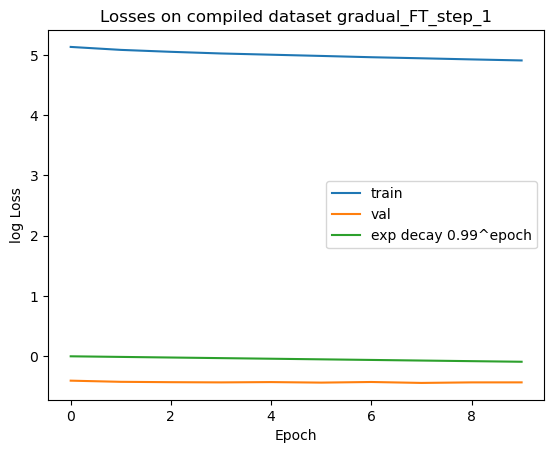

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_1_2023-05-03_15-53-47.pt
Initial size of dataset: 50000
Sampling 25.0% of the dataset
Final size of dataset: 50000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
Compiled dataset size: 18718
cpu
Epoch 1: Train loss = 76.4177, Val loss = 0.6000, Val BAC = 0.7191
Epoch 2: Train loss = 75.4200, Val loss = 0.6061, Val BAC = 0.7222
Epoch 3: Train loss = 74.3371, Val loss = 0.6095, Val BAC = 0.7272
Epoch 4: Train loss = 72.9337, Val loss = 0.5878, Val BAC = 0.7336
Epoch 5: Train loss = 72.0191, Val loss = 0.5963, Val BAC = 0.7326
Epoch 6: Train loss = 70.6086, Val loss = 0.5844, Val BAC = 0.7382
Epoch 7: Train loss = 69.9648, Val loss = 0.5888, Val BAC = 0.7393
Epoch 8: Train loss = 68.6444, Val loss = 0.5884, Val BAC = 0.7405
Epoch 9: Train loss = 67.9144, Val loss = 0.5712, Val BAC = 0.7475
Epoch 10: Train loss = 67.0703, Val loss = 0.5680, Val BAC = 0.7490
Final: Train loss = 67.0703, Val l

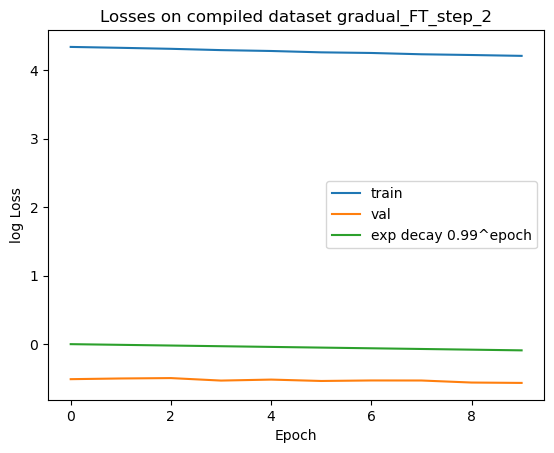

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_2_2023-05-03_15-54-14.pt
Initial size of dataset: 50000
Sampling 12.5% of the dataset
Final size of dataset: 50000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
Compiled dataset size: 12468
cpu
Epoch 1: Train loss = 42.0201, Val loss = 0.5341, Val BAC = 0.7574
Epoch 2: Train loss = 41.6874, Val loss = 0.5310, Val BAC = 0.7572
Epoch 3: Train loss = 40.8643, Val loss = 0.5170, Val BAC = 0.7628
Epoch 4: Train loss = 40.4587, Val loss = 0.5115, Val BAC = 0.7643
Epoch 5: Train loss = 40.0256, Val loss = 0.5129, Val BAC = 0.7662
Epoch 6: Train loss = 39.3862, Val loss = 0.5060, Val BAC = 0.7642
Epoch 7: Train loss = 38.8782, Val loss = 0.5025, Val BAC = 0.7708
Epoch 8: Train loss = 38.3158, Val loss = 0.4944, Val BAC = 0.7701
Epoch 9: Train loss = 37.7823, Val loss = 0.5022, Val BAC = 0.7727
Epoch 10: Train loss = 37.2403, Val loss = 0.4984, Val BAC = 0.7748
Final: Train loss = 37.2403, Val l

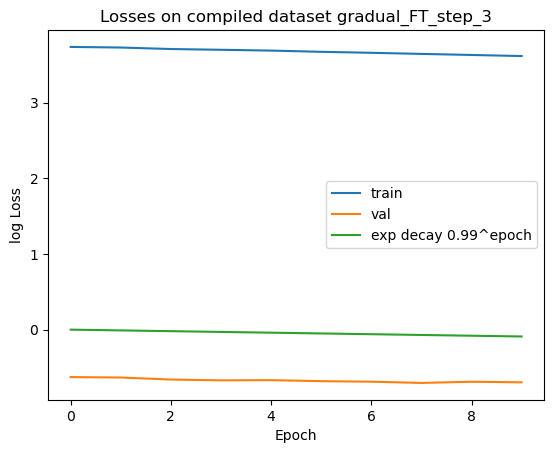

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_3_2023-05-03_15-54-31.pt
cpu
Epoch 1: Train loss = 3.8411, Val loss = 0.4569, Val BAC = 0.7763
Epoch 2: Train loss = 3.1156, Val loss = 0.4418, Val BAC = 0.7916
Epoch 3: Train loss = 2.6284, Val loss = 0.4623, Val BAC = 0.7871
Epoch 4: Train loss = 2.3996, Val loss = 0.4770, Val BAC = 0.7941
Epoch 5: Train loss = 2.1413, Val loss = 0.4705, Val BAC = 0.7922
Epoch 6: Train loss = 1.9778, Val loss = 0.4879, Val BAC = 0.7918
Epoch 7: Train loss = 1.7315, Val loss = 0.5215, Val BAC = 0.8055
Epoch 8: Train loss = 1.7360, Val loss = 0.5188, Val BAC = 0.7927
Epoch 9: Train loss = 1.5355, Val loss = 0.5635, Val BAC = 0.7989
Epoch 10: Train loss = 1.4557, Val loss = 0.5541, Val BAC = 0.7941
Final: Train loss = 1.4557, Val loss = 0.5541, Val BAC = 0.7912


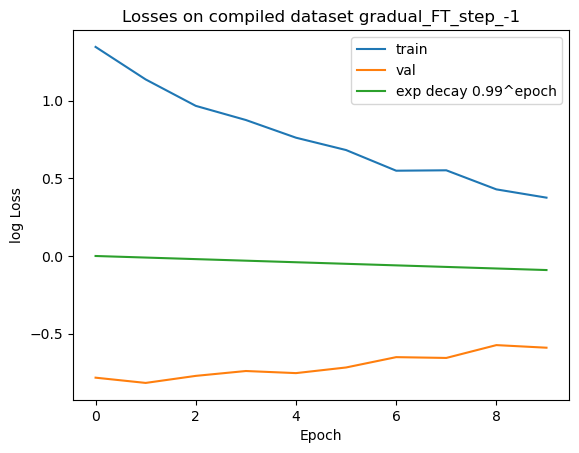

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_-1_2023-05-03_15-54-40.pt


'model_checkpoints/gradual_FT/gradual_FT_step_-1_2023-05-03_15-54-40.pt'

In [27]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
device = 'cpu'
# load in the broad tuned model
model = Classifier([2**11, 2**9, 2**6, 2**5, 2**0])
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
# model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
# plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
gradual_FT_params["learning_rate"] = 1e-5
gradual_FT_params["weight_decay"] = 0.0
gradual_FT_params["max_epochs"] = 10

rank = "Tanimoto"

Grad_FT_model, train_losses, val_losses = gradual_fine_tuning(model, federated_data=federated_data_ranked, clean_data=clean_data_ranked, gradual_FT_params=gradual_FT_params, validation_loader=validation_loader, rank=None)


# final step with the clean data
temp_params = copy.deepcopy(gradual_FT_params)

temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-4, rank=rank)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




cpu
Epoch 1: Train loss = 1.4339, Val loss = 0.6918, Val BAC = 0.5000
Epoch 2: Train loss = 1.4199, Val loss = 0.6936, Val BAC = 0.5000
Epoch 3: Train loss = 1.4059, Val loss = 0.6959, Val BAC = 0.5000
Epoch 4: Train loss = 1.3957, Val loss = 0.6984, Val BAC = 0.5000
Epoch 5: Train loss = 1.3885, Val loss = 0.7010, Val BAC = 0.5000
Epoch 6: Train loss = 1.3836, Val loss = 0.7034, Val BAC = 0.5000
Epoch 7: Train loss = 1.3765, Val loss = 0.7056, Val BAC = 0.5000
Epoch 8: Train loss = 1.3730, Val loss = 0.7075, Val BAC = 0.5000
Epoch 9: Train loss = 1.3674, Val loss = 0.7089, Val BAC = 0.5000
Epoch 10: Train loss = 1.3641, Val loss = 0.7097, Val BAC = 0.5000
Epoch 11: Train loss = 1.3605, Val loss = 0.7101, Val BAC = 0.5000
Epoch 12: Train loss = 1.3576, Val loss = 0.7099, Val BAC = 0.5000
Epoch 13: Train loss = 1.3520, Val loss = 0.7093, Val BAC = 0.5000
Epoch 14: Train loss = 1.3488, Val loss = 0.7085, Val BAC = 0.5000
Epoch 15: Train loss = 1.3435, Val loss = 0.7075, Val BAC = 0.5000


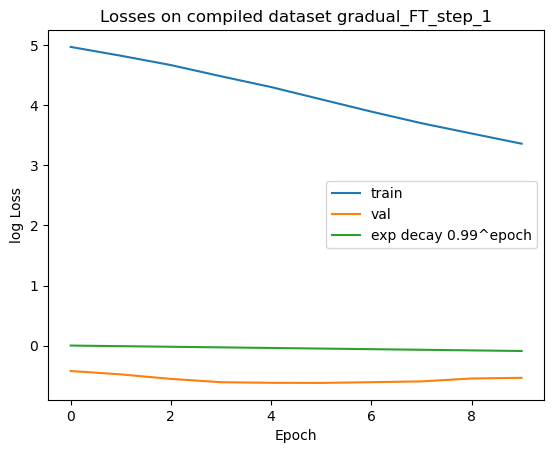

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_1_2023-05-03_16-02-14.pt
Initial size of dataset: 50000
Sampling 25.0% of the dataset
Final size of dataset: 50000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
Compiled dataset size: 18718
cpu
Epoch 1: Train loss = 15.9346, Val loss = 0.5765, Val BAC = 0.7903
Epoch 2: Train loss = 14.1707, Val loss = 0.5753, Val BAC = 0.8073
Epoch 3: Train loss = 11.9729, Val loss = 0.6184, Val BAC = 0.7987
Epoch 4: Train loss = 11.3029, Val loss = 0.6215, Val BAC = 0.8019
Epoch 5: Train loss = 10.2200, Val loss = 0.6666, Val BAC = 0.7996
Epoch 6: Train loss = 9.6422, Val loss = 0.6875, Val BAC = 0.8021
Epoch 7: Train loss = 8.8482, Val loss = 0.6926, Val BAC = 0.7934
Epoch 8: Train loss = 8.4006, Val loss = 0.6769, Val BAC = 0.7964
Epoch 9: Train loss = 7.9530, Val loss = 0.7011, Val BAC = 0.8069
Epoch 10: Train loss = 7.9004, Val loss = 0.7194, Val BAC = 0.8002
Final: Train loss = 7.9004, Val loss = 

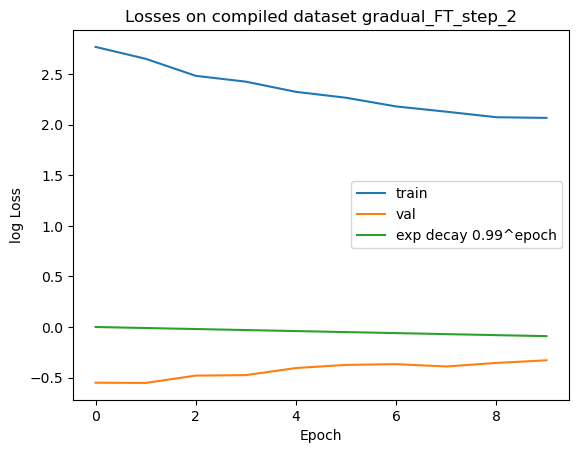

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_2_2023-05-03_16-02-53.pt
Initial size of dataset: 50000
Sampling 12.5% of the dataset
Final size of dataset: 50000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
Compiled dataset size: 12468
cpu
Epoch 1: Train loss = 7.7717, Val loss = 0.7241, Val BAC = 0.8003
Epoch 2: Train loss = 5.8501, Val loss = 0.7453, Val BAC = 0.7995
Epoch 3: Train loss = 6.0759, Val loss = 0.7733, Val BAC = 0.7956
Epoch 4: Train loss = 5.6344, Val loss = 0.7426, Val BAC = 0.8016
Epoch 5: Train loss = 5.2756, Val loss = 0.7904, Val BAC = 0.7882
Epoch 6: Train loss = 4.7150, Val loss = 0.7884, Val BAC = 0.8012
Epoch 7: Train loss = 4.8382, Val loss = 0.7815, Val BAC = 0.7927
Epoch 8: Train loss = 4.7570, Val loss = 0.7843, Val BAC = 0.8008
Epoch 9: Train loss = 4.5853, Val loss = 0.7667, Val BAC = 0.7993
Epoch 10: Train loss = 4.0417, Val loss = 0.7917, Val BAC = 0.7932
Final: Train loss = 4.0417, Val loss = 0.791

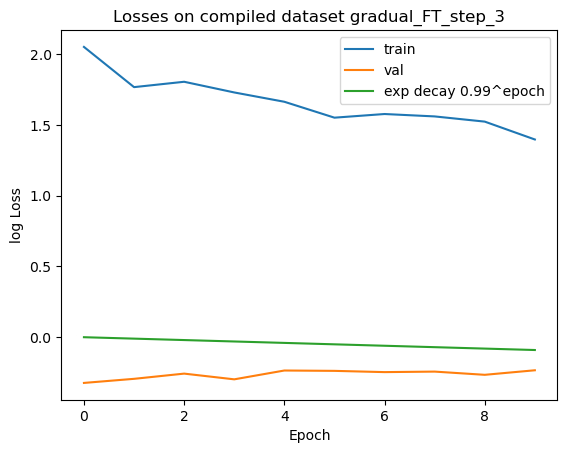

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_3_2023-05-03_16-03-11.pt
cpu
Epoch 1: Train loss = 3.8259, Val loss = 0.6960, Val BAC = 0.7827
Epoch 2: Train loss = 2.3506, Val loss = 0.6131, Val BAC = 0.7920
Epoch 3: Train loss = 1.7592, Val loss = 0.6071, Val BAC = 0.8054
Epoch 4: Train loss = 1.5488, Val loss = 0.6356, Val BAC = 0.8007
Epoch 5: Train loss = 1.4704, Val loss = 0.6441, Val BAC = 0.7932
Epoch 6: Train loss = 1.3935, Val loss = 0.6552, Val BAC = 0.7889
Epoch 7: Train loss = 1.3789, Val loss = 0.6296, Val BAC = 0.7990
Epoch 8: Train loss = 1.2640, Val loss = 0.6433, Val BAC = 0.8026
Epoch 9: Train loss = 1.2465, Val loss = 0.6564, Val BAC = 0.7997
Epoch 10: Train loss = 1.2055, Val loss = 0.6519, Val BAC = 0.8021
Final: Train loss = 1.2055, Val loss = 0.6519, Val BAC = 0.7946


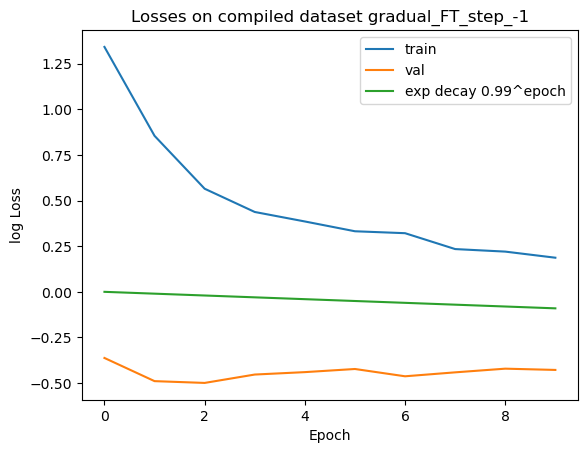

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_-1_2023-05-03_16-03-21.pt


'model_checkpoints/gradual_FT/gradual_FT_step_-1_2023-05-03_16-03-21.pt'

In [30]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
device = 'cpu'
# load in the broad tuned model
model = Classifier([2**11, 2**9, 2**6, 2**5, 2**0])
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=1e-4)
                                              
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
gradual_FT_params["learning_rate"] = 1e-4
gradual_FT_params["weight_decay"] = 0.0
gradual_FT_params["max_epochs"] = 10

rank = "Tanimoto"

Grad_FT_model, train_losses, val_losses = gradual_fine_tuning(model, federated_data=federated_data_ranked, clean_data=clean_data_ranked, gradual_FT_params=gradual_FT_params, validation_loader=validation_loader, rank=None)


# final step with the clean data
temp_params = copy.deepcopy(gradual_FT_params)

temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3, rank=rank)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)


